In [16]:
import pandas as pd
import numpy as np
import os
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load your data
pitch_data = pd.DataFrame(pd.read_csv('jazmine-pitch.csv'))
words_data = pd.DataFrame(pd.read_csv('jazmine-words.csv'))

In [27]:
words_data

,timestamp,frequency,duration,word
0,1.340952,249.746,0.354104,o
1,1.700862,227.212,0.092880,o
2,1.799546,195.799,0.116100,o
3,1.921451,180.507,0.104490,o
4,2.281361,171.493,0.603719,say
...,...,...,...,...
270,126.775147,732.630,0.272834,brave
271,127.059592,729.911,0.911383,brave
272,127.976780,731.244,0.011610,brave
273,127.994195,365.839,0.011610,brave


In [29]:
# Giving repeated words unique labels
def unique_word_labels(data):
    word_count = {}
    last_word = None
    unique_data = []

    for index, row in data.iterrows():
        word = row['word']
        
        # Check if this is a repeated word
        if word == last_word:
            # Use the same label as the previous occurrence if it's in a clump
            unique_word = unique_data[-1]['word']
        else:
            # If it's a new occurrence or a different word
            count = word_count.get(word, 0) + 1
            word_count[word] = count

            if count == 1:
                unique_word = word  # First occurrence remains the same
            else:
                unique_word = f"{word}-{count}"  # Label subsequent occurrences uniquely

        # Creating a new dictionary with modified word property
        new_item = row.to_dict()
        new_item['word'] = unique_word
        unique_data.append(new_item)

        last_word = word  # Update the last seen word

    
    return pd.DataFrame(unique_data)

words_data = unique_word_labels(words_data)

In [4]:
def get_word_data(word, words_data, pitch_data):
    word_notes = words_data[words_data['word'] == word]
    start_time = word_notes['timestamp'].min()
    end_time = word_notes.iloc[-1]['timestamp'] + word_notes.iloc[-1]['duration']

    # Adjusting the timestamps relative to the word's start
    adjusted_word_notes = word_notes.copy()
    adjusted_word_notes['adjusted_timestamp'] = adjusted_word_notes['timestamp'] - start_time

    # Filtering and adjusting pitch data
    filtered_pitch_data = pitch_data[(pitch_data['timestamp'] >= start_time) & (pitch_data['timestamp'] <= end_time)].copy()
    filtered_pitch_data['adjusted_timestamp'] = filtered_pitch_data['timestamp'] - start_time

    return {
        'word': word,
        'note_data': adjusted_word_notes,
        'pitch_data': filtered_pitch_data
    }

def chaos_score(pitch_data1, pitch_data2):
    # Using FastDTW for a quick approximation
    distance, _ = fastdtw(pitch_data1, pitch_data2, dist=euclidean)
    return distance

In [30]:
# Create distance matrix
unique_words = words_data['word'].unique()
shapes = [get_word_data(word, words_data, pitch_data) for word in unique_words]
num_shapes = len(shapes)
distance_matrix = []
filename = "distance_matrix.npy"

# Check if the file exists
if os.path.exists(filename):
    # Load the distance matrix
    distance_matrix = np.load(filename)
    print("Loaded distance matrix from file.")
    print(distance_matrix)
else:
    num_shapes = len(shapes)
    distance_matrix = []

    for i, shape1 in enumerate(shapes):
        row = []
        for j, shape2 in enumerate(shapes):
            if i == j:
                # Skip comparing the shape with itself and set distance to 0
                distance = 0
            else:
                distance = chaos_score(shape1['pitch_data'], shape2['pitch_data'])
            row.append(distance)
        distance_matrix.append(row)

        # Print progress
        print(f"Processed shape {i+1} of {num_shapes}")

    # Convert to numpy array for easy saving
    distance_matrix = np.array(distance_matrix)

    # Save the distance matrix to a file
    np.save(filename, distance_matrix)
    print("Distance matrix computation complete and saved to file.")

['o' 'say' 'can' 'you' 'see' 'by' 'the' 'dawns' 'early' 'light' 'what'
 'so' 'proudly' 'we' 'hailed' 'at' 'the-2' 'twilights' 'last' 'gleaming'
 'whose' 'broad' 'stripes' 'and' 'bright' 'stars' 'through' 'the-3'
 'perilous' 'fight' 'oer' 'the-4' 'ramparts' 'we-2' 'watched' 'were'
 'so-2' 'gallantly' 'streaming' 'and-2' 'the-5' 'rockets' 'red' 'glare'
 'the-6' 'bombs' 'bursting' 'in' 'air' 'gave' 'proof' 'through-2' 'the-7'
 'night' 'that' 'our' 'flag' 'was' 'still' 'there' 'o-2' 'say-2' 'does'
 'that-2' 'star' 'spangled' 'banner' 'yet' 'wave' 'oer-2' 'the-8' 'land'
 'of' 'the-9' 'free' 'and-3' 'the-10' 'home' 'of-2' 'the-11' 'brave']
Loaded distance matrix from file.
[[     0.           7312.13734958   4275.91421185 ...  28652.02648392
  118053.84281147 261476.16193406]
 [  7312.13734958      0.           1809.5931509  ...  56106.39338461
  146996.25291324 302014.50724078]
 [  4275.91421185   1809.5931509       0.         ...  19435.0381983
  143664.97982844 300090.30083361]
 ...
 [ 28

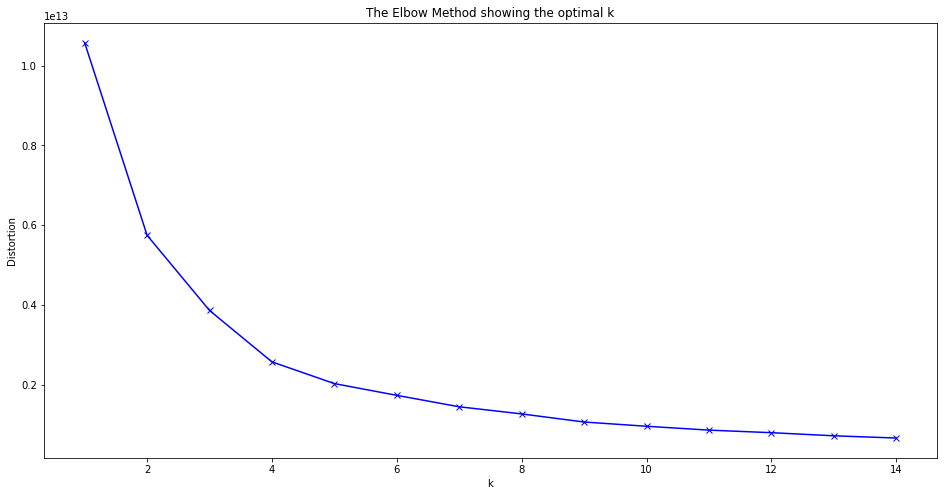

In [20]:
# Elbow method
distortions = []
K = range(1, 15)  # Range of k values to try.

for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=10)
    kmeanModel.fit(distance_matrix)
    distortions.append(kmeanModel.inertia_)

# Plotting
plt.figure(figsize=(16, 8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [31]:
# K-means
k = 12
kmeans = KMeans(n_clusters=k, n_init=10)
clusters = kmeans.fit_predict(distance_matrix)
print(clusters)

[ 5  5  5  5  3  0  4  0  6  6 11 11  8  0  3 11  0  3 11  6 11  5  5  5
  5  3  4  4  6  3 11  0  7  0  3 11  0  6  6  4  4  7  8 10  4  4  7  4
 10  8  8  0  4  3  0  0  3  8  8 10  8  4  0  0  0  3  7  0  9 11 11  4
  4  4  2  4  4  1  4  1  2]


In [32]:
# Show clusters
clustered_words = pd.DataFrame({
    'word': unique_words,
    'cluster': clusters
})

# Grouping clusters
grouped = clustered_words.groupby('cluster')

for cluster, group in grouped:
    print(f"Cluster {cluster}:")
    words_in_cluster = group['word'].tolist()
    print(", ".join(words_in_cluster))
    print()  # Adding a blank line for better readability

Cluster 0:
by, dawns, we, the-2, the-4, we-2, so-2, through-2, that, our, does, that-2, star, yet

Cluster 1:
home, the-11

Cluster 2:
free, brave

Cluster 3:
see, hailed, twilights, stars, fight, watched, night, flag, spangled

Cluster 4:
the, through, the-3, and-2, the-5, the-6, bombs, in, the-7, say-2, land, of, the-9, and-3, the-10, of-2

Cluster 5:
o, say, can, you, broad, stripes, and, bright

Cluster 6:
early, light, gleaming, perilous, gallantly, streaming

Cluster 7:
ramparts, rockets, bursting, banner

Cluster 8:
proudly, red, gave, proof, was, still, o-2

Cluster 9:
wave

Cluster 10:
glare, air, there

Cluster 11:
what, so, at, last, whose, oer, were, oer-2, the-8



In [34]:
def plot_word_clusters(clustered_words, words_data, pitch_data):
    # Group by cluster
    for cluster in clustered_words['cluster'].unique():
        print(f"Cluster {cluster}:")
        plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

        # Get the words in this cluster
        words_in_cluster = clustered_words[clustered_words['cluster'] == cluster]['word']
        print(words_in_cluster)

        for word in words_in_cluster:
            # Filter the pitch data for this word
            word_pitch_data = pitch_data[pitch_data['word'] == word]

            # Plot
            plt.plot(word_pitch_data['timestamp'], word_pitch_data['frequency'], label=word)
        
        plt.xlabel('Timestamp')
        plt.ylabel('Frequency')
        plt.title(f'Word Frequency Patterns in Cluster {cluster}')
        plt.legend()
        plt.show()
        
plot_word_clusters(clustered_words, words_data, pitch_data)

Cluster 5:
0           o
1         say
2         can
3         you
21      broad
22    stripes
23        and
24     bright
Name: word, dtype: object


KeyError: 'word'

<Figure size 864x432 with 0 Axes>